In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
!cp '/content/drive/MyDrive/BUSI_256x256_Aug.zip' '/content/'
!unzip '/content/BUSI_256x256_Aug.zip' -d '/content/' &> /dev/null
os.remove('/content/BUSI_256x256_Aug.zip')

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
# from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import img_to_array,load_img, array_to_img
from tensorflow.keras.optimizers import Adam
# from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import warnings
warnings.filterwarnings("ignore")
random.seed(42)
import cv2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras import backend as keras
from keras.applications.densenet import DenseNet201, DenseNet121
import skimage.io as io
# import skimage.transform as trans
import glob
from PIL import Image
import skimage
from keras.initializers import Constant
from sklearn.metrics import jaccard_score

In [4]:
import random
random.seed(42)
seed = 42
batch_size = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
im_width = 256
im_height = 256

In [5]:
import shutil
def makDirectory(dirPath):
  if (not os.path.exists(dirPath)):
    os.makedirs(dirPath)

oldImagesDir = '/content/BUSI_256x256_Aug/train/x'
oldMasksDir = '/content/BUSI_256x256_Aug/train/y'

imagesPath = '/content/TrainingDataset/images'
masksPath = '/content/TrainingDataset/masks'


makDirectory(imagesPath)
makDirectory(masksPath)

shutil.move(oldImagesDir,imagesPath)
shutil.move(oldMasksDir,masksPath)


oldImagesDir2 = '/content/BUSI_256x256_Aug/test/x'
oldMasksDir2 = '/content/BUSI_256x256_Aug/test/y'

imagesPath2 = '/content/TestDataset/images'
masksPath2 = '/content/TestDataset/masks'


makDirectory(imagesPath2)
makDirectory(masksPath2)

shutil.move(oldImagesDir2,imagesPath2)
shutil.move(oldMasksDir2,masksPath2)


'/content/TestDataset/masks/y'

In [ ]:
# tf.keras.preprocessing.image.ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator
                    #  featurewise_center=True,
                    #  featurewise_std_normalization=True,
                    #  rotation_range=90,
                    #  width_shift_range=0.1,
                    #  height_shift_range=0.1,

data_gen_args = dict(rescale=1 / 255.0,
                     horizontal_flip=True,
                     validation_split=0.2)
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
##############3# training data
image_generator_training = image_datagen.flow_from_directory(
    '/content/TrainingDataset/images',
    class_mode=None,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode = 'rgb',
    batch_size = batch_size,
    subset='training',
    seed=seed)
mask_generator_training = mask_datagen.flow_from_directory(
    '/content/TrainingDataset/masks',
    class_mode=None,
     target_size=(IMG_HEIGHT, IMG_WIDTH),
     color_mode = 'grayscale',
     batch_size = batch_size,
     subset='training',
    seed=seed)

############## validation data
image_generator_validation = image_datagen.flow_from_directory(
    '/content/TrainingDataset/images',
    class_mode=None,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode = 'rgb',
    batch_size = batch_size,
    subset='validation',
    seed=seed)
mask_generator_validation = mask_datagen.flow_from_directory(
    '/content/TrainingDataset/masks',
    class_mode=None,
     target_size=(IMG_HEIGHT, IMG_WIDTH),
     color_mode = 'grayscale',
     batch_size = batch_size,
     subset='validation',
    seed=seed)
# training_generator = zip(image_generator_training, mask_generator_training)
# validation_generator = zip(image_generator_validation, mask_generator_validation)
def image_mask_generator(image_gen, mask_gen):
    while True:
        # Load images and masks from respective generators
        images = next(image_gen) # Changed this line
        masks = next(mask_gen) # Changed this line

        # Ensure masks have the correct shape for binary segmentation
        masks = masks[:,:,:,0]  # Remove the extra dimension
        masks = masks.reshape(masks.shape[0], masks.shape[1], masks.shape[2], 1)  # Add back channel dimension

        yield images, masks  # Yield as a tuple for model training
training_generator = image_mask_generator(image_generator_training, mask_generator_training)
validation_generator = image_mask_generator(image_generator_validation, mask_generator_validation)

Found 2588 images belonging to 1 classes.
Found 2588 images belonging to 1 classes.
Found 647 images belonging to 1 classes.
Found 647 images belonging to 1 classes.


In [ ]:
#                     #  featurewise_center=True,
#                     #  featurewise_std_normalization=True,
#                     #  rotation_range=90,
#                     #  width_shift_range=0.1,
#                     #  height_shift_range=0.1,

# data_gen_args = dict(rescale=1 / 255.0,
#                     #  horizontal_flip=True,
#                      validation_split=0.2)
# image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
# mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
# # Provide the same seed and keyword arguments to the fit and flow methods
# ##############3# training data
# image_generator_training = image_datagen.flow_from_directory(
#     '/content/TrainingDataset/images',
#     class_mode=None,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     color_mode = 'rgb',
#     batch_size = batch_size,
#     subset='training',
#     seed=seed)
# mask_generator_training = mask_datagen.flow_from_directory(
#     '/content/TrainingDataset/masks',
#     class_mode=None,
#      target_size=(IMG_HEIGHT, IMG_WIDTH),
#      color_mode = 'grayscale',
#      batch_size = batch_size,
#      subset='training',
#     seed=seed)

# ############## validation data
# image_generator_validation = image_datagen.flow_from_directory(
#     '/content/TestDataset/images',
#     class_mode=None,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     color_mode = 'rgb',
#     batch_size = batch_size,
#     # subset='validation',
#     seed=seed)
# mask_generator_validation = mask_datagen.flow_from_directory(
#     '/content/TestDataset/masks',
#     class_mode=None,
#      target_size=(IMG_HEIGHT, IMG_WIDTH),
#      color_mode = 'grayscale',
#      batch_size = batch_size,
#     #  subset='validation',
#     seed=seed)
# # combine generators into one which yields image and masks

# # training_generator = zip(image_generator_training, mask_generator_training)
# # validation_generator = zip(image_generator_validation, mask_generator_validation)

# def image_mask_generator(image_gen, mask_gen):
#     while True:
#         # Load images and masks from respective generators
#         images = next(image_gen) # Changed this line
#         masks = next(mask_gen) # Changed this line

#         # Ensure masks have the correct shape for binary segmentation
#         masks = masks[:,:,:,0]  # Remove the extra dimension
#         masks = masks.reshape(masks.shape[0], masks.shape[1], masks.shape[2], 1)  # Add back channel dimension

#         yield images, masks  # Yield as a tuple for model training

# # Combine image and mask generators
# train_generator = image_mask_generator(image_generator_training, mask_generator_training)
# test_generator = image_mask_generator(image_generator_validation, mask_generator_validation)

In [ ]:
# import shutil
# shutil.rmtree('/content/TestDataset')
# shutil.rmtree('/content/BUSI_256x256_Aug')

In [ ]:
# # from keras import backend as K
# import tensorflow.keras.backend as K
# def dice_coef(y_true, y_pred,smooth = 10):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_coef_loss(y_true, y_pred):
#     return 1-dice_coef(y_true, y_pred)

# def Jaccard_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

# def Jaccard_coef_loss(y_true, y_pred):
#     return (1-Jaccard_coef(y_true, y_pred))

# def bcc_dice_coef_loss(y_true, y_pred):
#      return (binary_crossentropy(y_true, y_pred)+(dice_coef_loss(y_true, y_pred)))

# def bcc_Jaccard_coef_loss(y_true, y_pred):
#     return (binary_crossentropy(y_true, y_pred)+(1-Jaccard_coef(y_true, y_pred)))


In [6]:
import tensorflow as tf
from tensorflow.keras.backend import sum

def dice_coef(y_true, y_pred, smooth=10):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    # print(f"y_true_f shape: {y_true_f.shape}, y_pred_f shape: {y_pred_f.shape}")  # Check shapes
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def Jaccard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    # print(f"y_true_f shape: {y_true_f.shape}, y_pred_f shape: {y_pred_f.shape}")  # Check shapes
    intersection = sum(y_true_f * y_pred_f)
    return intersection / (sum(y_true_f) + sum(y_pred_f) - intersection)

def Jaccard_coef_loss(y_true, y_pred):
    return 1 - Jaccard_coef(y_true, y_pred)



In [7]:
def bcc_dice_coef_loss(y_true, y_pred):
    return (tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred))

def bcc_Jaccard_coef_loss(y_true, y_pred):
    return (tf.keras.losses.binary_crossentropy(y_true, y_pred) + (1 - Jaccard_coef(y_true, y_pred)))


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Softmax
import keras.backend as K

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Softmax

class GlobalSpatialAttention(Layer):
    def __init__(self, in_channel, factor=8):
        super().__init__()
        self.in_channel = in_channel
        self.factor = factor

        # Define Conv2D layers in __init__ to persist across calls
        self.proj_query = Conv2D(filters=self.in_channel // self.factor, kernel_size=1, padding='same', kernel_initializer='he_normal')
        self.proj_key = Conv2D(filters=self.in_channel // self.factor, kernel_size=1, padding='same', kernel_initializer='he_normal')
        self.proj_value = Conv2D(filters=self.in_channel, kernel_size=1, padding='same', kernel_initializer='he_normal')

    def build(self, input_shape):
        B, H, W, C = input_shape
        dim = H * W
        self.weight = self.add_weight(
            shape=(dim, dim),
            initializer="random_normal",
            trainable=True,
            name="attention_weight"
        )

    def call(self, x):
        shape = tf.shape(x)
        B, H, W, C = shape[0], shape[1], shape[2], shape[3]

        proj_query = self.proj_query(x)
        proj_query = tf.reshape(proj_query, [B, H * W, -1])

        proj_key = self.proj_key(x)
        proj_key = tf.reshape(proj_key, [B, -1, H * W])

        energy = tf.matmul(proj_query, proj_key)
        attention = Softmax()(energy)

        proj_value = self.proj_value(x)
        proj_value = tf.reshape(proj_value, [B, -1, H * W])

        output = tf.matmul(proj_value, attention)
        output = tf.matmul(output, self.weight)
        output = tf.reshape(output, [B, H, W, -1])

        return output + x


class ScaledDotProductAttention(Layer):
    def __init__(self, temperature, dropout=0.1):
        super().__init__()
        self.temperature = tf.math.sqrt(tf.cast(temperature, tf.float32))
        self.dropout = Dropout(rate=dropout)

    def call(self, x, mask=None):
        """
        x: shape (B, H, W, C) -> Needs reshaping
        mask: shape (B, H*W, H*W) or None
        """

        shape = tf.shape(x)
        B, H, W, C = shape[0], shape[1], shape[2], shape[3]

        # Flatten spatial dimensions: (B, H, W, C) → (B, H*W, C)
        x = tf.reshape(x, (B, H * W, C))

        # Query, Key, and Value are the same for self-attention
        query, key, value = x, x, x

        # Transpose Key for attention computation: (B, C, H*W) → (B, H*W, C)
        key_T = tf.transpose(key, perm=[0, 2, 1])

        # Scaled dot-product attention
        energy = tf.matmul(query, key_T) / self.temperature

        # Apply optional mask
        if mask is not None:
            energy = tf.where(mask == 0, -1e9, energy)

        attention = Softmax()(energy)
        attention = self.dropout(attention)

        # Compute attention output
        output = tf.matmul(attention, value)  # (B, H*W, C)

        # Reshape back to (B, H, W, C)
        output = tf.reshape(output, (B, H, W, C))

        return output


import tensorflow as tf
from tensorflow.keras.layers import Layer, Embedding, concatenate

class PositionEncoding(Layer):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        # Move Embedding layers to __init__
        self.h_embedding_layer = Embedding(input_dim=self.in_dim, output_dim=self.out_dim, name='h_embedding')
        self.w_embedding_layer = Embedding(input_dim=self.in_dim, output_dim=self.out_dim, name='w_embedding')

    def call(self, x):
        shape = tf.shape(x)
        B, H, W, C = shape[0], shape[1], shape[2], shape[3]

        h_range = tf.range(H)
        w_range = tf.range(W)

        # Use pre-initialized Embedding layers
        h_embedding = self.h_embedding_layer(h_range)
        h_embedding = tf.expand_dims(h_embedding, axis=1)
        h_embedding = tf.repeat(h_embedding, repeats=W, axis=1)

        w_embedding = self.w_embedding_layer(w_range)
        w_embedding = tf.expand_dims(w_embedding, axis=0)
        w_embedding = tf.repeat(w_embedding, repeats=H, axis=0)

        position_encoding = concatenate([h_embedding, w_embedding], axis=-1)
        position_encoding = tf.expand_dims(position_encoding, axis=0)
        position_encoding = tf.repeat(position_encoding, repeats=B, axis=0)

        return position_encoding


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate, Multiply, Add, GlobalAveragePooling2D, GlobalMaxPooling2D

def sem_attention_block(inputs):
    shape = inputs.shape  # Dynamic shape

    # Initial Feature Extraction
    F2 = Conv2D(inputs.shape[-1], kernel_size=3, padding='same')(inputs)
    F2 = BatchNormalization()(F2)
    F2 = Activation('relu')(F2)

    # Global Max and Average Pooling
    x1 = GlobalMaxPooling2D(keepdims=True)(F2)  # Instead of MaxPooling2D
    x2 = GlobalAveragePooling2D(keepdims=True)(F2)  # Instead of AveragePooling2D

    # Concatenation of pooled features
    con1 = Concatenate()([x1, x2])

    # Feature Refinement
    F3 = Conv2D(inputs.shape[-1], kernel_size=3, padding='same')(con1)
    F3 = BatchNormalization()(F3)
    F3 = Activation('relu')(F3)

    # Squeeze and Excitation Attention
    xa = GlobalAveragePooling2D(keepdims=True)(inputs)
    xa = Conv2D(inputs.shape[-1], kernel_size=1, padding='same')(xa)  # Change 3 → 1
    xa = BatchNormalization()(xa)
    xa = Activation('sigmoid')(xa)

    # Attention Scaling
    xm = Multiply()([F3, xa])

    # Residual Connection
    xam = Add()([inputs, xm])

    return xam

In [10]:
from tensorflow import keras
def AN(nClasses, input_height, input_width):

    #------------------------------Define Input Shape----------------------------------

    img_input = Input(shape=(input_height, input_width, 3)) # defining the Input shape

    #Load DenseNet121 from keras. This model is initialized with the ImageNet.
    #This part is responsible for the feature extraction which is so called convolution
    # part of the semantic segmentation (Encoder).

    Encoder_Dense = DenseNet121( weights = 'imagenet',
						include_top = False,
						input_tensor = img_input)
    # Encoder1 = Encoder_Dense.output
    Encoder = tf.keras.layers.Conv2D(filters = 256,
					kernel_size = (3, 3),
					activation = 'relu',
					kernel_initializer='he_normal',
					padding="same")(Encoder_Dense.output)
    Encoder1 = BatchNormalization()(Encoder)
#--------------------------------------------------------
    encoder7_gsa = GlobalSpatialAttention(in_channel=256)(Encoder1)

    pe = PositionEncoding(in_dim=8, out_dim=256//2)(Encoder1)
    encoder7_pe = Encoder1 + pe

    encoder7_sdpa = ScaledDotProductAttention(temperature=256)(encoder7_pe)
    att_layer = encoder7_gsa + encoder7_sdpa

    # Decoding the encoded features to reconstruct the original input shape Image.

    Decoder_s = keras.layers.UpSampling2D(size = (2, 2))(att_layer)
    s44 = sem_attention_block(Decoder_s)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool3_pool").output, s44], axis=-1)
    Decoder = tf.keras.layers.Conv2D(filters = 256,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder1 = BatchNormalization()(Decoder)

    Decoder_ss = keras.layers.UpSampling2D(size = (2, 2))(Decoder1)
    s33 = sem_attention_block(Decoder_ss)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool2_pool").output, s33], axis=-1)
    Decoder = tf.keras.layers.Conv2D(filters = 128,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder2 = BatchNormalization()(Decoder)

    Decoder_sss = keras.layers.UpSampling2D(size = (2, 2))(Decoder2)
    s22 = sem_attention_block(Decoder_sss)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool1").output, s22], axis=-1)
    Decoder = tf.keras.layers.Conv2D(filters = 64,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder3 = BatchNormalization()(Decoder)

    Decoder_ssss = keras.layers.UpSampling2D( size = (2, 2))(Decoder3)
    s11 = sem_attention_block(Decoder_ssss)
    Decoder = concatenate([Encoder_Dense.get_layer(name="conv1_bn").output, s11], axis=-1)
    Decoder = tf.keras.layers.Conv2D(filters = 32,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder4 = BatchNormalization()(Decoder)

    Decoder = keras.layers.UpSampling2D(size = (2, 2))(Decoder4)
    Decoder = tf.keras.layers.Conv2D(filters = 16,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder5 = BatchNormalization()(Decoder)
    Decoder = tf.keras.layers.Conv2D(filters = nClasses,
						kernel_size = (1, 1),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder5)


    Predicted_Mask = tf.keras.layers.Conv2D(filters = 1,
									kernel_size = 1,
									activation = 'sigmoid')(Decoder)

    AN_model = Model(inputs = img_input, outputs = [Predicted_Mask])
    # AN_model = Model(inputs = img_input, outputs = outputs)

    return AN_model

In [11]:
model = AN(1, im_height, im_width)
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 15,517,121 (59.19 MB)

 Trainable params: 15,427,713 (58.85 MB)

 Non-trainable params: 89,408 (349.25 KB)

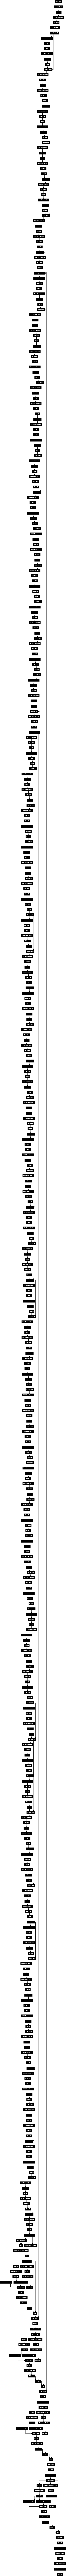

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False
)

In [ ]:
# dot_img_file = '/tmp/model_1.png'
# keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-09)
# model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.compile(optimizer = adam,
                loss = bcc_Jaccard_coef_loss,
                metrics = ["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=9, min_delta=0.001)
anne = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, verbose=1, min_lr=1e-9)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/DUNet_TransformerAttention_SEM_BUSI_4_3_25.weights.h5', verbose=1, save_best_only=True,save_weights_only=True)
callbacks = [anne, checkpoint, Earlystop]

In [ ]:
nb_epochs = 155
history = model.fit(
    training_generator,
    steps_per_epoch=len(image_generator_training),
    # steps_per_epoch = 150,
    validation_data = validation_generator,
    validation_steps=len(image_generator_validation),
    # validation_steps = 100,
    epochs = nb_epochs,
    callbacks=[callbacks])

Epoch 1/155
y_true_f shape: (None,), y_pred_f shape: (None,)
y_true_f shape: (None,), y_pred_f shape: (None,)
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8221 - loss: 1.3816y_true_f shape: (None,), y_pred_f shape: (None,)

Epoch 1: val_loss improved from inf to 5.39516, saving model to /content/drive/MyDrive/DUNet_TransformerAttention_SEM_BUSI_4_3_25.weights.h5
81/81 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.8230 - loss: 1.3799 - val_accuracy: 0.2911 - val_loss: 5.3952 - learning_rate: 0.0010
Epoch 2/155
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9428 - loss: 0.9762
Epoch 2: val_loss improved from 5.39516 to 1.31000, saving model to /content/drive/MyDrive/DUNet_TransformerAttention_SEM_BUSI_4_3_25.weights.h5
81/81 ━━━━━━━━━━━━━━━━━━━━ 60s 738ms/step - accuracy: 0.9429 - loss: 0.9754 - val_accuracy: 0.8749 - val_loss: 1.3100 - learning_rate: 0.0010
Epoch 3/155
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9547 - loss: 0.7496
Epoch 3: val_loss improved 

In [ ]:
# nb_epochs = 150
# # Calculate steps_per_epoch and validation_steps
# # training_steps_per_epoch = len(train_generator)  # Assuming image_generator_training has the length of your training dataset
# # validation_steps_per_epoch = len(test_generator)  # Assuming image_generator_validation has the length of your validation dataset

# history = model.fit(
#     train_generator,
#     steps_per_epoch=len(image_generator_training),
#     validation_data=test_generator,
#     validation_steps=len(image_generator_validation),
#     epochs=nb_epochs, callbacks = callbacks
# )

In [12]:
im_width = 256
im_height = 256
path_train = '/content/TestDataset/images'

In [13]:
# Get and resize train images and masks
def get_data(path):
    images_paths = os.path.join(path,'x')
    masks_paths = os.path.join(path,'y')

    images_ids = sorted(os.listdir(images_paths))
    masks_ids = sorted(os.listdir(masks_paths))

    X = np.zeros((len(images_ids), im_height, im_width, 3), dtype=np.float32)
    y = np.zeros((len(masks_ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n in range (len(images_ids)):
        # Load images

        img = load_img(os.path.join(images_paths,images_ids[n]), color_mode='rgb')
        x_img = img_to_array(img)
        x_img = resize(x_img, (im_height, im_width, 3), mode='constant', preserve_range=True)

        # Load masks

        # mask = img_to_array(load_img(os.path.join(masks_paths,masks_ids[n]), grayscale=True))
        # mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)
        mask_img = load_img(os.path.join(masks_paths,masks_ids[n]))
        mask = img_to_array(mask_img) # Convert to grayscale here
        mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)
        # Save images
        X[n] = x_img / 255
        y[n] = mask / 255
    print('Done!')
    return X, y

X, y = get_data(path_train)

Getting and resizing images ... 
Done!


In [14]:
from keras.models import load_model
model.load_weights('/content/drive/MyDrive/DUNet_TransformerAttention_SEM_BUSI_4_3_25.weights.h5')

In [15]:
y_pred = model.predict(X, verbose=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 52s 15s/step


In [16]:
y_pred = np.asarray(y_pred)

In [17]:
from sklearn.metrics import confusion_matrix
from skimage.measure import label, regionprops
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import jaccard_score
from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings("ignore")

def evaluate_metrics(y_test, y_pred):
    n = y_pred.shape[0]
    all_accuracy = np.zeros(n)
    all_dice = np.zeros(n)
    all_jaccard = np.zeros(n)
    all_sensitivity = np.zeros(n)
    all_specificity = np.zeros(n)
    all_precision = np.zeros(n)
    for i in range(n):
        gt, pred = y_test[i], y_pred[i]
        gt_flt = np.ndarray.flatten(gt)
        pred_flt = np.ndarray.flatten(pred)

        precisions, recalls, thresholds = precision_recall_curve(gt_flt, pred_flt)
        f1 = 2*(precisions * recalls) / (precisions + recalls)
        max_value = np.argmax(f1)
        # precision, recall, thres = precisions[max_value], recalls[max_value], thresholds[max_value]
        thres = thresholds[max_value]
        # maxval = 255
        # pred_mask= (pred>= thres)
        pred_mask = (pred_flt >= thres)
        pred_label = pred_mask*1
        # pred_label = np.ndarray.flatten(pred_label)

        tn, fp, fn, tp = confusion_matrix(gt_flt, pred_label).ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        iou = tp / (tp + fp + fn)
        dice = 2*tp / (2*tp + fp + fn)
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)

        all_accuracy[i] = accuracy
        all_dice[i] = dice
        all_jaccard[i] = iou
        all_sensitivity[i] = recall
        all_specificity[i] = specificity
        all_precision[i] = precision

    print('Accuracy: {:4f}, Dice: {:4f}, Jaccard: {:4f}, Sensitivity: {:4f}, Specificity: {:4f}, precision: {:4f}'.format(
        np.nanmean(all_accuracy), np.nanmean(all_dice), np.nanmean(all_jaccard), np.nanmean(all_sensitivity), np.nanmean(all_specificity), np.nanmean(all_precision)
    ))
    return all_accuracy, all_dice, all_jaccard, all_sensitivity, all_specificity,  all_precision

In [18]:
y_test = np.asarray(y).astype(bool)*255

In [19]:
y_test = y_test/255

In [20]:
evl = evaluate_metrics(y_test, y_pred)

Accuracy: 0.997373, Dice: 0.972768, Jaccard: 0.947541, Sensitivity: 0.971503, Specificity: 0.998413, precision: 0.974182


In [ ]:
preds_test = np.asarray(y_pred)

In [ ]:
for i in range(80):
  plt.imsave("/content/drive/MyDrive/DUNet_TransformerAttention_SEM_BUSI_4_3_25/segmentation/"+str(i+1)+".png",preds_test[i,:,:,0],cmap='gray') # binary segmenation
  plt.imsave("/content/drive/MyDrive/DUNet_TransformerAttention_SEM_BUSI_4_3_25/masks/"+str(i+1)+".tiff",y_test[i,:,:,0],cmap='gray') # binary segmenation

In [ ]:
flops = 0
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        output_shape = layer.output_shape[1:]  # Exclude batch dimension
        kernel_shape = layer.kernel.shape
        flops += output_shape[0] * output_shape[1] * output_shape[2] * \
                 kernel_shape[0] * kernel_shape[1] * kernel_shape[2]
    elif isinstance(layer, tf.keras.layers.Dense):
        output_shape = layer.output_shape[1:]  # Exclude batch dimension
        kernel_shape = layer.kernel.shape
        flops += output_shape[0] * kernel_shape[0] * kernel_shape[1]

# Print the total FLOPs
print("Total FLOPs: {:.2f} GFLOPs".format(flops / 1e9))


AttributeError: 'Conv2D' object has no attribute 'output_shape'

In [ ]:
memory_usage = model.count_params() * 4  # Assuming float32 data type (4 bytes per parameter)
print("Memory Usage: {:.2f} KB".format(memory_usage / 1024))

In [ ]:
import time
start_time=time.time()
model.predict(X)
end_time=time.time()
duration= end_time-start_time
hours = duration // 3600
minutes = (duration - (hours * 3600)) // 60
seconds = (duration - ((hours * 3600) + (minutes * 60)))
# msg = f"training elapsed time was" {str(hours)} hours, {:4.2f} minutes, {:4.2f} seconds)
print (hours) # print out training duration time
print (minutes)
print (seconds)